
# Covid-19 data analysis

## Getting started

Imports section. You basically neet to install the JupyterLab, MatPlotLib, NumPy, Pandas, PyGal (including the world map) and Pillow libraries. To use some interactions in the notebook we are using ipywidgets as well.  
These are the pip commands to install the packes:

```bash
pip install jupyterlab  
pip install pandas  
pip install matplolib  
pip install ipywidgets
pip install pygal
pip install pygal_maps_world
pip install pillow 
```
  
In order to get ipywidgets working with jupyter notebook please run the following command: 

```bash
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```
    
If you're using jupyter lab you also have to register the extension: `

```bash
jupyter labextension install @jupyter-widgets/jupyterlab-manager  
```
  
Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)  
  
When exectuing the second command you may wonder that the terminal is somehow standing still. Don't worry, start the jupyter notebook in a second terminal using:

```bash
jupyter lab
```
  
For your convenience we added all of these individual installation to one requirements text file that you can execute using the one and only following command (you will find requirements.txt in the root folder of this project): 

```bash
pip install -r requirements.txt  
```


In [1]:
import pandas as pd
import numpy as np
import math
import re
import time
import datetime
import os
import requests
import re
from datetime import timedelta, date
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from CovidCases import CovidCases
from CovidCasesWHO import CovidCasesWHO
from PlotterBuilder import PlotterBuilder
import CovidMap as dfm
from IPython.display import SVG, display


/Users/cmbt/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)



## The CovidCases class

The CovidCases class gives us a number of attributes which we want to use. The constructor takes a string containing the full filename of a CSV database you can down load from the WHO website:<br>
  
[European Center of Disease Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) 
  
For your convenience the class provides a static method to download the file. The database will be loaded and kept as a private member. To retrieve the data for an individual country or a list of countries you can use the public methods ```GetCountryDataByGeoID``` or ```GetCountryDataByCountryName```. Refer to the CSV file for a list of available GeoIDs and CountryNames. Both methods will return a list of the following attributes as a Pandas data frame:  

### Data attributes published by the class

```Date``` The date of the data  
```Country``` The name of the country  
```GeoID``` The GeoID of the country such as FR for France or DE for Germany  
  
```DailyCases``` The number of cases on that day  
```Cases``` The accumulated number of cases since the 31.12.2019  
```DoublingTime``` The number of days in which the number of cases will be doubled  
  
```DailyDeaths``` The number of deaths on the date  
```Deaths``` The accumulated number of deaths since the 31.12.2019   
```PercentDeaths``` The number of deaths in % of the cases  
  
```CasesPerMillionPopulation``` The number of cumulative cases divided by the population of the country in million      
```DeathsPerMillionPopulation``` The number of cumulative deaths divided by the population of the country in million  

### Class methods

To generate the data frame you can use one of the following methods:

```get_country_data_by_geoid_list```  
Returns a dataframe by a list of geoIDs. Refer to the CSV file for a list of available GeoIDs and CountryNames.

```get_country_data_by_geoid_string_list```  
Returns a dataframe by a comma separeted list of geoIDs such as "DE, UK, FR". Refer to the CSV file for a list of available GeoIDs and CountryNames.

```get_all_country_data```  
Returns a dataframe of all countries in the database.

The class also offers some usefull methods to generate more attributes:

```add_lowpass_filter_for_attribute```  
This function will lowpass any of the above attributes. The width of the lowpass is given by the number ```n```. The name of the newly created attribute is the given name with a tailing number ```n```. E.g. if you filter the attribute ```DailyCases``` with ```n = 7``` then the function will add a newly created attribute named ```DailyCases7```.

```add_r0```  
This function is used to calculate an estimation for the reproduction number R0. If you call that function it will add a newly created attribute named ```R```. This attribute should be filtered by a lowpass of width ```n = 7``` as shown in this example. 

```add_incidence_7day_per_100Kpopulation```  
The function calculates the accumulated 7-day incidence. This is the sum of daily cases of the last 7 days divided by the population given as 100000 citizens. After calling the function a new attribute called ```Incidence7DayPer100Kpopulation``` will be added to the data frame.

```download_CSV_file```  
Automatically downloads the database file if it doesn't exists.  

```save_df_to_csv```  
If required you may want to save the results to a CSV file. To do so you can use this function.

```get_available_GeoID_list```  
This function generates a data frame that consists of the GeoIDs and the country names that are included in the ECDC data. It will help you finding the GeoID od a country. 

```get_pygal_european_geoid_list```  
```get_pygal_american_geoid_list```  
```get_pygal_asian_geoid_list```  
```get_pygal_african_geoid_list```  
```get_pygal_oceania_geoid_list```  
Returns a list of GeoIDs of the countries of that continent that are available in PayGal and the WHO data. **Be aware**:  
Not all countries of the WHO are available in PayGal and some names are different (GB in PyGal = UK in WHO, GR in PyGal = EL in WHO). PyGal uses lower case and WHO upper case.  

```get_pygal_european__string_list```  
```get_pygal_american__string_list```  
```get_pygal_asian__string_list```  
```get_pygal_african__string_list```  
```get_pygal_oceania__string_list```  
Returns a comma separated string of GeoIDs of the countries of that continent that are available in PayGal and the WHO data. **Be aware**:  
Not all countries of the WHO are available in PayGal and some names are different (GB in PyGal = UK in WHO, GR in PyGal = EL in WHO). PyGal uses lower case and WHO upper case.  


### Using the class

Using the CovidCases class is pretty simple. Create an instance of the class using the full path to the filename of the downloaded dataset and get the data for a specific list of countries by calling<br> <i>df = covidCases.get_country_data_by_geoid_string_list('DE, IT, ES')</i>. The list is a comma separated sting of GeoIDs. The geoID is equal to the country code of a toplevel domain. E.g. <i>DE</i> for Germany, <i>FR</i> for France, <i>JP</i> for Japan or <i>KR</i> for Korea. There is also a function in which you can pass a list of strings having the GeoIDs of the requested countries individually. This function is called ```get_country_data_by_geoid_list```. You can also get a data frame containing all countries by calling ```get_all_country_data```. 




## The PlotterBuilder class

We also use the PlotterBuilder class in this project to plot the data. It's very much configured for our needs of plotting a Pandas DataFrame. When using it you have to pass the name of the DataFrame column you want to plot as a constructor argument. Afterwards you're able to configure multiple plotting configurations like ```Name```, ```figure_size```, ```y-axis scale```, ```title`` and so on. In the end you pass the DataFrame that should be plotted to the function ```plot_dataFrame``` and it outputs a beautiful matplotlib plot.



## Generate graphs

As a start we have to download the database from the ECDC servers if we haven't downloaded it already. Selecting the countries that we want to show can be done viw a comma separated list of GeoID's:


In [2]:
path_to_csv = CovidCasesWHO.download_CSV_file()
# create an instance
covidCases = CovidCasesWHO(path_to_csv)
# a list of countries of whom we want to get the data as a comma separated list
countryList = 'DE, GB, FR, ES, IT, CH, AT'

using existing file: /Users/cmbt/Documents/GitHub/Covid-19-analysis/./data/2021-01-02-WHO-db.csv
Pandas loading the WHO CSV: 1.5657200813293457s



Next we want to visualize the data in several diagrams. In a first step we need to get the data fields of the different countries that we want to visualize. Next is to select the field that we want to display, indexed by the date having the country name as a column.


/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: invalid value encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])
/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: divide by zero encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])


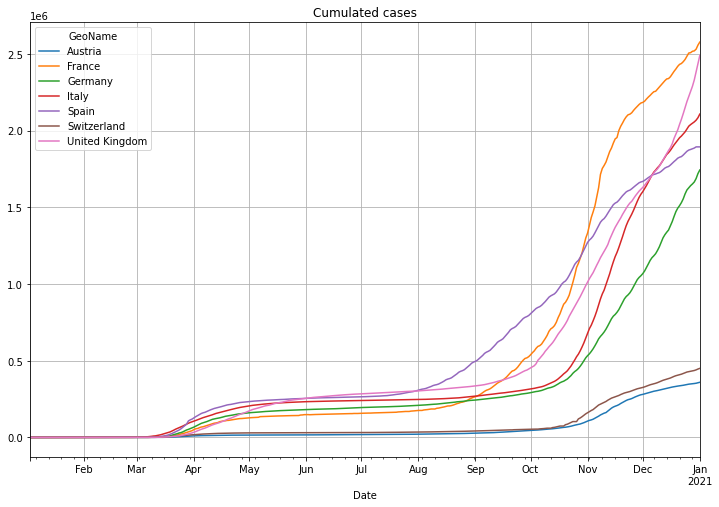

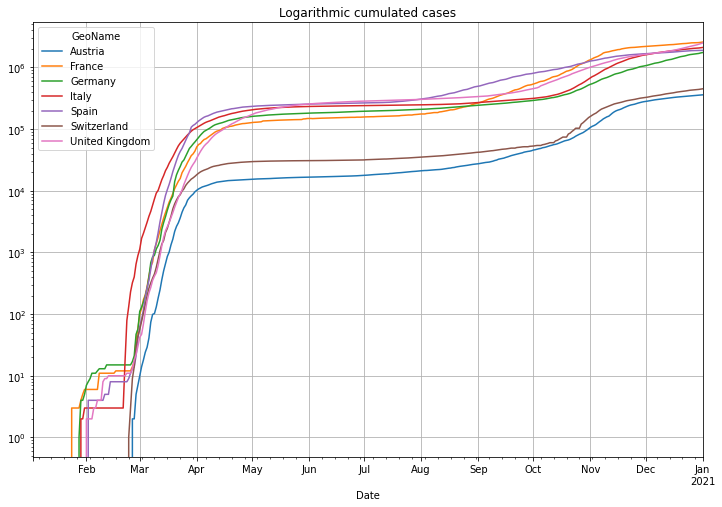

In [3]:

# get the data
df = covidCases.get_data_by_geoid_string_list(countryList)
    
# plot with various axes scales, first with linear axis scale:
(PlotterBuilder('Cases') 
    .set_title('Cumulated cases') 
    .set_grid() 
    .plot_dataFrame(df))

# the logarithmic cumulated cases
(PlotterBuilder('Cases')
    .set_title('Logarithmic cumulated cases')
    .set_grid()
    .set_log()
    .plot_dataFrame(df))



The following shows a graph of cases per day (Notice: UK did something very strange: early July they reported -30000 new cases. The fact that a country corrects previous numbers is somehow normal. But correcting 30000 cases at one day makes it very difficult to analyse the data. To avoid the graph from being 'unreadable' we introduced the limit of the y-axis):
    

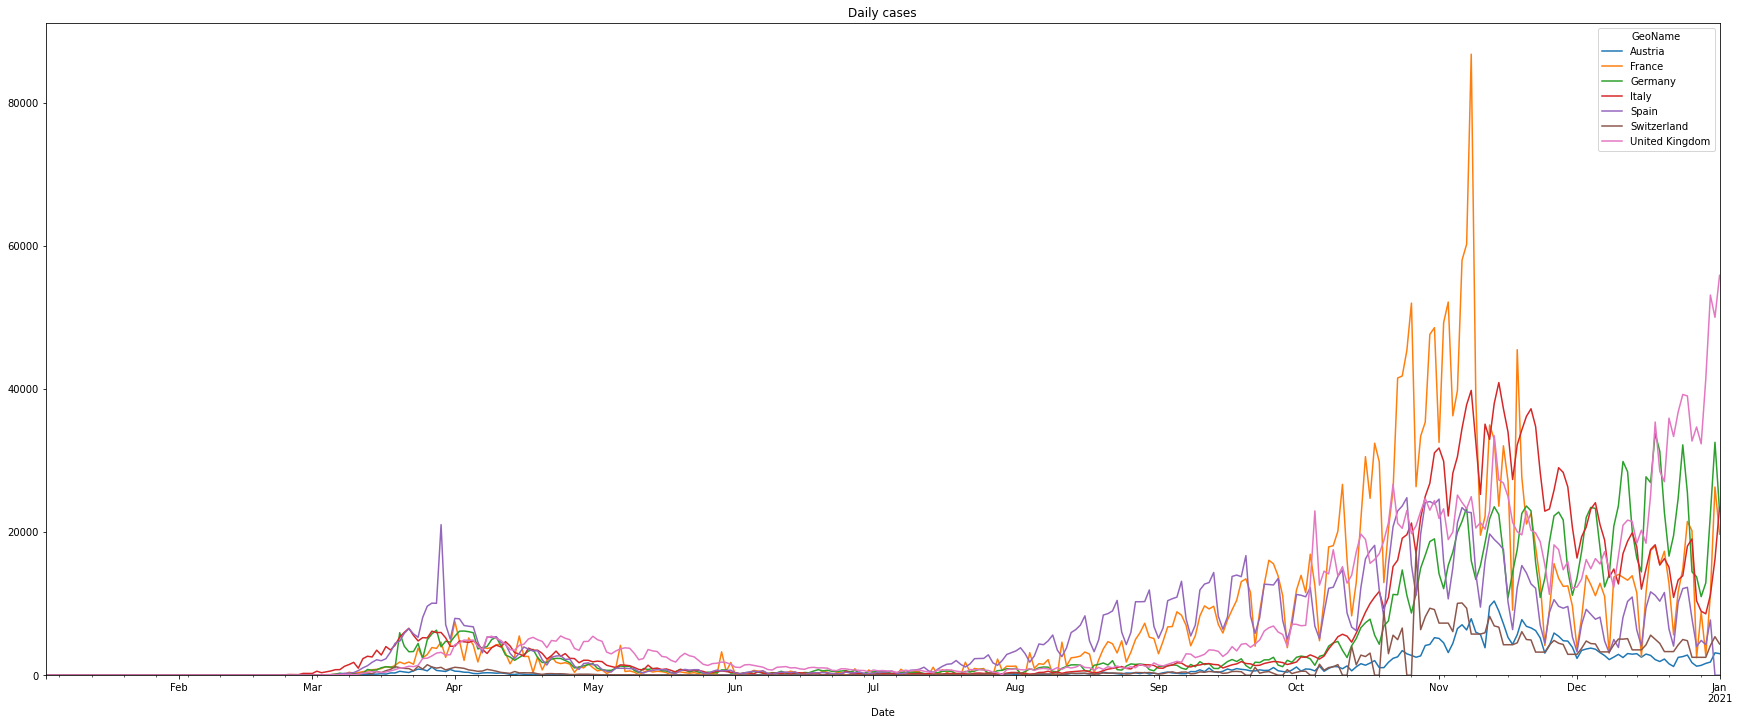

In [4]:

# plot the daily cases, a bar chart doesn't make sense for a longer time
(PlotterBuilder('DailyCases')
     .set_figsize((30, 12))
     .set_title('Daily cases')
     .plot_dataFrame(df, ylim_min=0))



It's difficult to read the graph as we can see the typical *weekend* behavior when the data of the cases are partly not updated. To get rid of this we will visualize the rolling 7-day average number of cases:


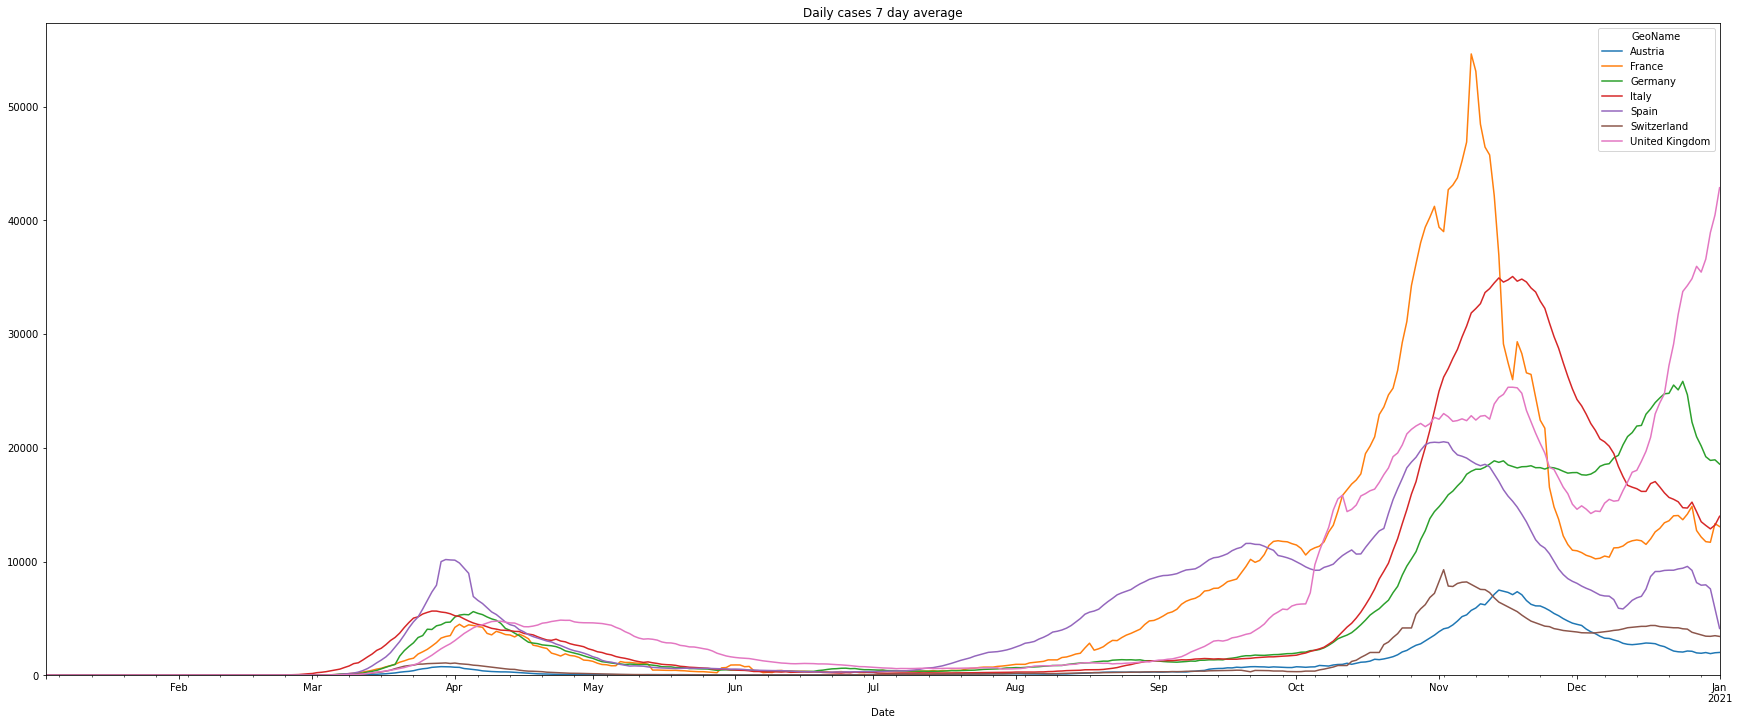

In [5]:

# filter the data of the number of daily cases
df = covidCases.add_lowpass_filter_for_attribute(df, 'DailyCases', 7)

# plot the filtered daily cases
(PlotterBuilder('DailyCases7')
     .set_figsize((30, 12))
     .set_title('Daily cases 7 day average')
     .plot_dataFrame(df, ylim_min=0))



Now the graphs of the deaths. For the graph of the daily deaths we again use a 7 day average:


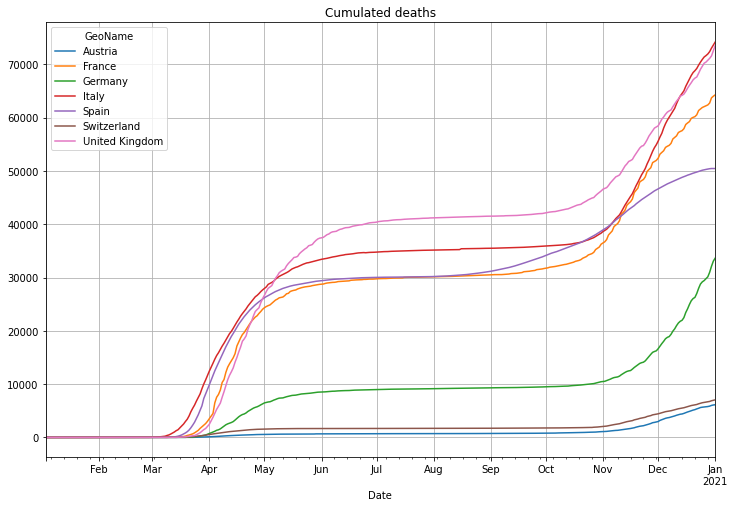

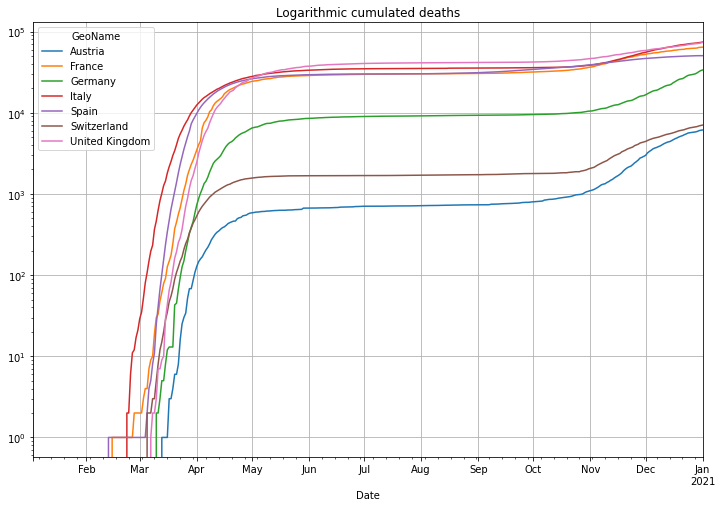

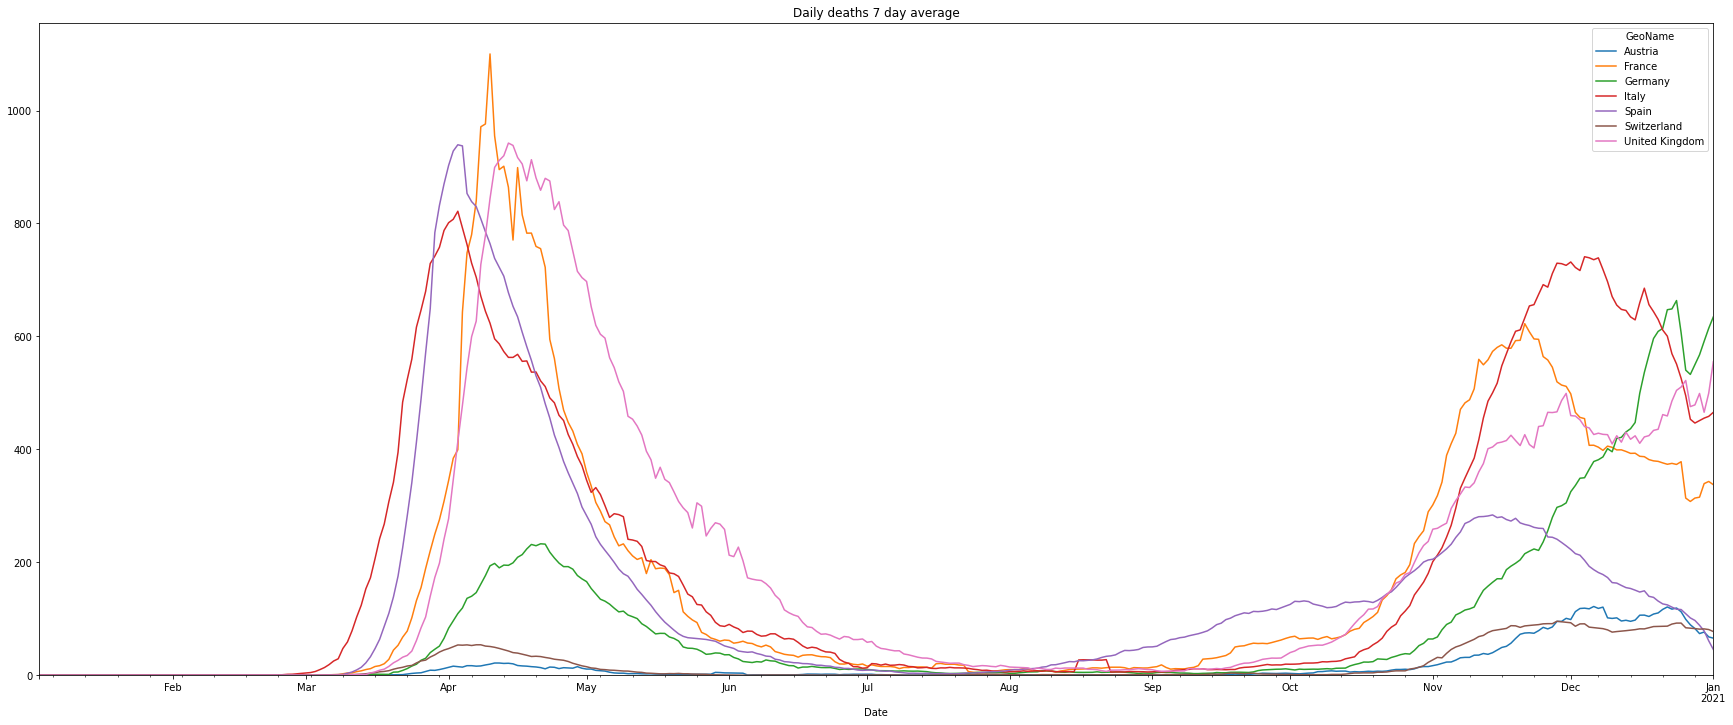

In [6]:

# plot cumulated deaths
(PlotterBuilder('Deaths')
     .set_title('Cumulated deaths')
     .set_grid()
     .plot_dataFrame(df))

# plot cumulated deaths in logarithmic y-axis scale
(PlotterBuilder('Deaths')
     .set_title('Logarithmic cumulated deaths')
     .set_grid()
     .set_log()
     .plot_dataFrame(df))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'DailyDeaths', 7)

# plot the filtered daily cases
(PlotterBuilder('DailyDeaths7')
     .set_figsize((30, 12))
     .set_title('Daily deaths 7 day average')
     .plot_dataFrame(df, ylim_min=0))



Next is the number of deaths in percent of the cases. This is called Case-Fatality-Rate (CFR), if you test enough this value is a good estimation of the Infection-Fatality-Rate (IFR) that also includes cases that have not been tested. There is an interesting, not finished (17.04.2020), study in the village of Gangelt, Heinsberg county Germany, with 12000 citizen. A couple from the town was spending vacation in the Italian Lombardian area, the first hotspot in Italy. When they came back from vacation they attended 3 carnival parties in the village. Beside that the woman was working in a kinder garden. Both have been infected and the village became the first hotspot in Germany after a smaller outbreak at a Webasto fab in Bavaria. A team of the virology institute at the university of Bonn headed by professor Hendrik Streeck tested 509 persons of 240 households on antibodies of Sars-CoV-2. As a result they found out that statistically 15% of the citizen had already antibodies, meaning an infection with Covid-19. Taking the amount of infected people and the number of deaths in the village into account it turns out, that the death rate was only 0,37%, a pretty low number. This leads to a simple problem: if the reported number of cases is low, then the death rate will be significantly higher. Interestingly Germany is doing Covid-19 tests massively and the death rate is significantly lower than in other countries with a higher death rate. This might be an indicator of less tests and therefore a high number of 'dark cases', cases that are not confirmed due to not enough tests.


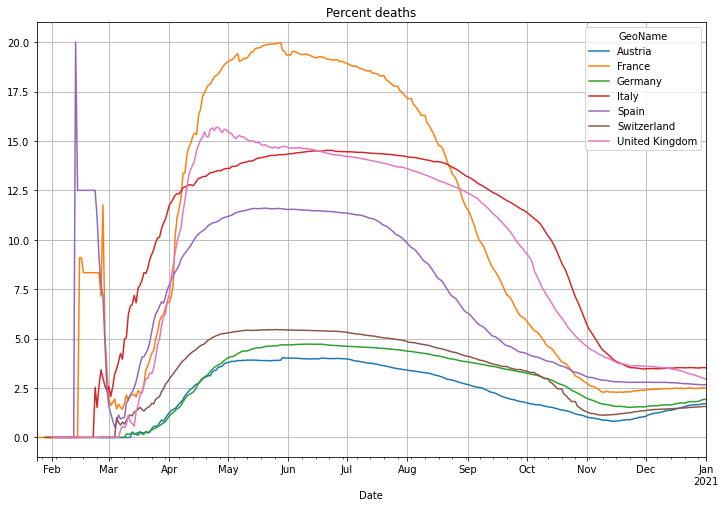

In [7]:

# plot the percent deaths with linear scale
(PlotterBuilder('PercentDeaths')
    .set_title('Percent deaths')
    .set_grid()
    .plot_dataFrame(df))



Now the number of cases per million population:
    

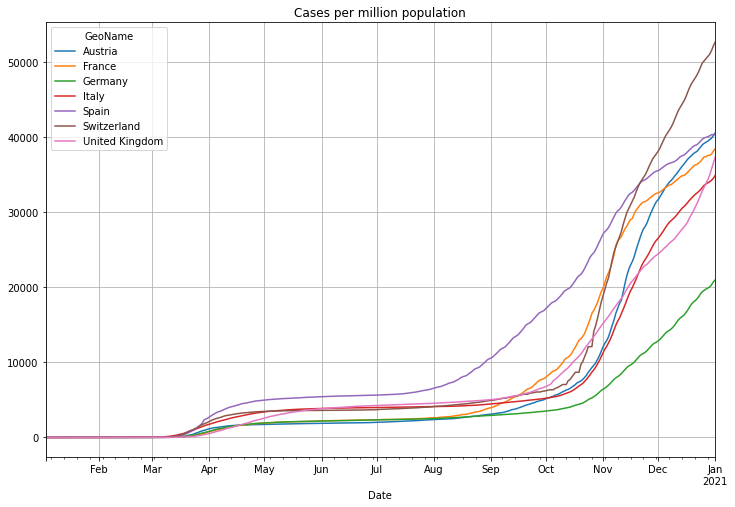

In [8]:

# plot the daily doubling time with linear scale
(PlotterBuilder('CasesPerMillionPopulation')
    .set_title('Cases per million population')
    .set_grid()
    .plot_dataFrame(df))



Now the number of deaths per million population. Be aware: some countries report not all deaths. The United Kingdom for instance reported in the beginning of the pandamic only people that died in NHS facilities:
    

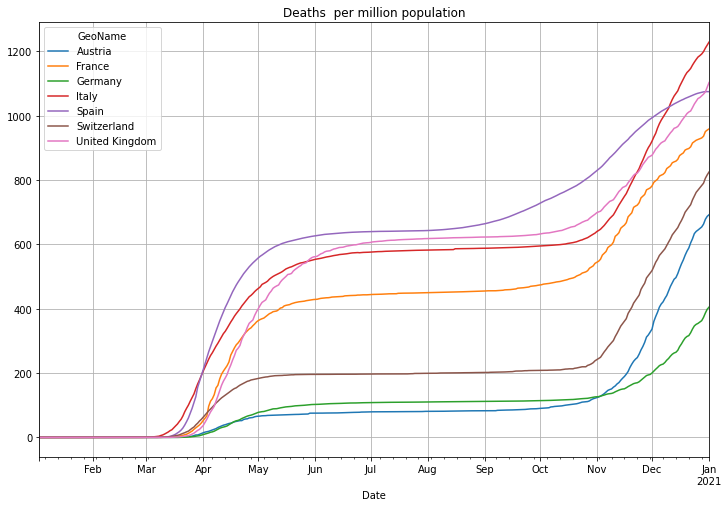

In [9]:

# plot the daily doubling time with linear scale
(PlotterBuilder('DeathsPerMillionPopulation')
    .set_title('Deaths  per million population')
    .set_grid()
    .plot_dataFrame(df))



The doubling time stands for the number of days it needs to double the number of cases. The number is useful during an exponential growth (roughly up to a number of 20 days). The higher this number, the less exponential and the better the situation is. After a pandemic becomes more linear it becomes more important to look to the reproduction rate, refer to the end of this document to view it. We also show a 7 day average of this number using a maximum value of 20 for the y-axis. By doing this we can see the start of the pandemic much easier.
    

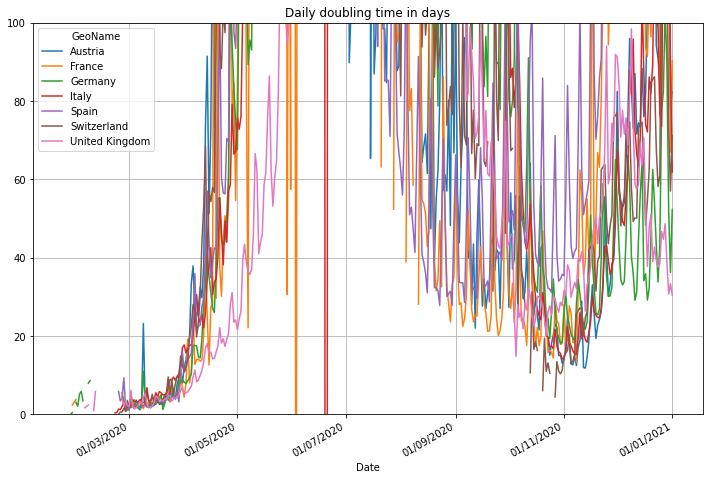

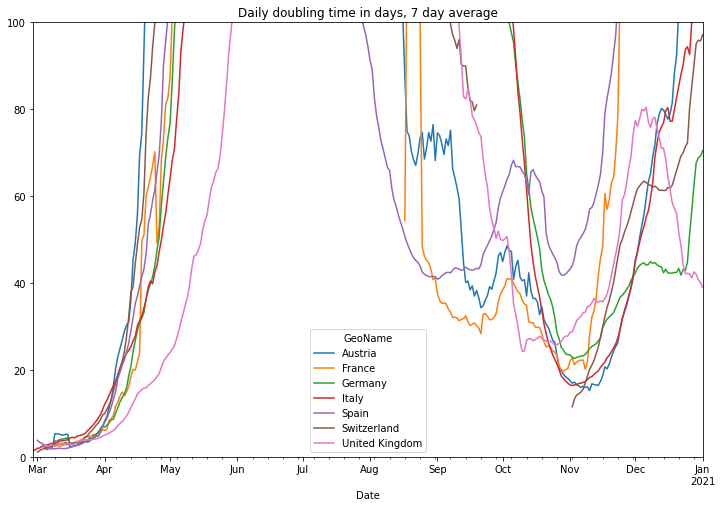

In [10]:

# plot the daily doubling time with linear scale
(PlotterBuilder('DoublingTime')
    .set_title('Daily doubling time in days')
    .set_grid()
    .plot_dataFrame(df, ylim_min=0, ylim_max=100))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'DoublingTime', 7)

# plot the filtered daily cases
(PlotterBuilder('DoublingTime7')
     .set_title('Daily doubling time in days, 7 day average')
     .plot_dataFrame(df, ylim_min=0, ylim_max=100))




### Alignment of the data

Now we will align the data to the day when the cumulative cases first exceeded the number of 100 cases. This will help us understanding the different speed of the outbreak in different countries. Graphs which started delayed, or better, started horizontally shifted in the plots above will now be aligned on the left. The units on the horizontal axis is now <i>Number of Days</i>. Because of the alignment the graphs will be longer or shorter depending on the number of days since the country exceeded 100 cases.


/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: invalid value encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])
/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: divide by zero encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])


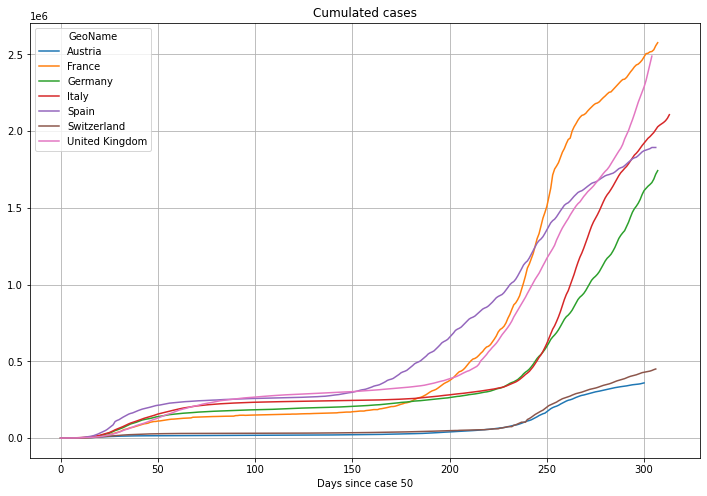

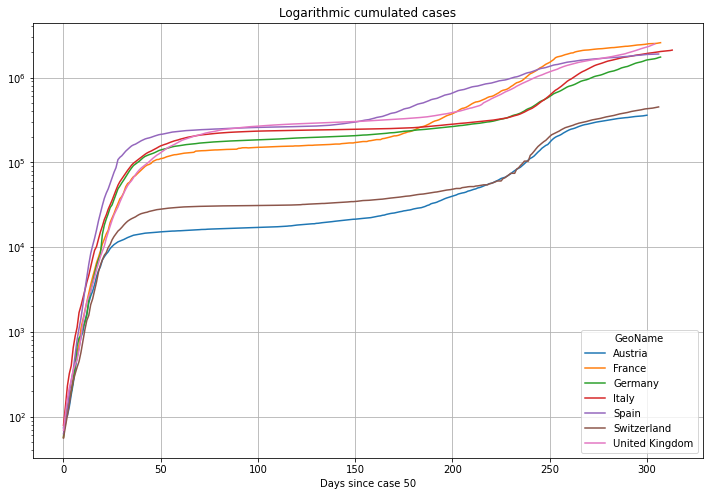

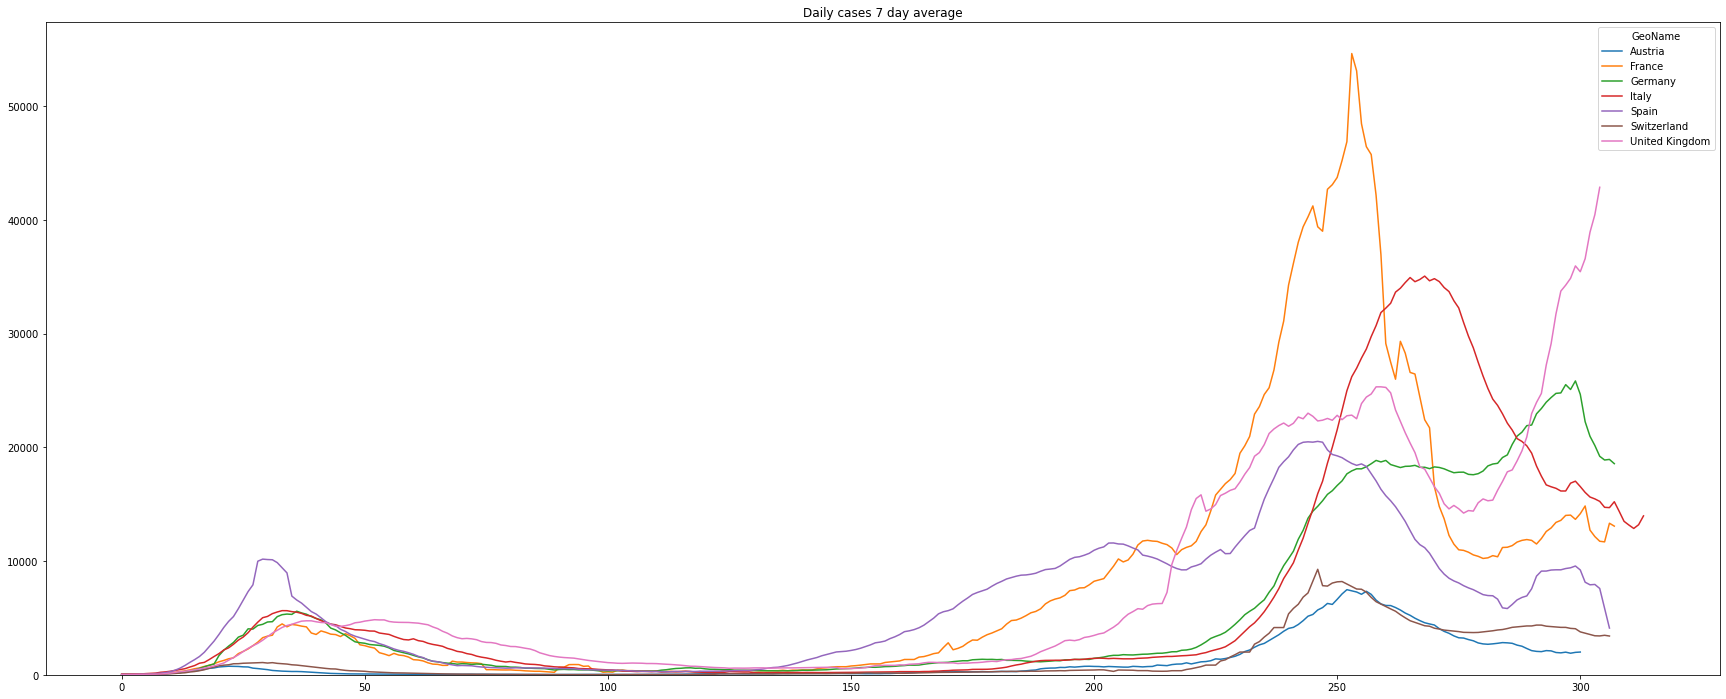

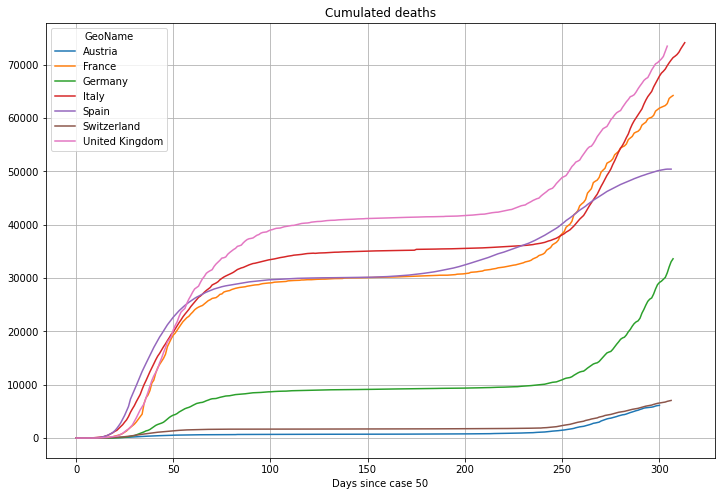

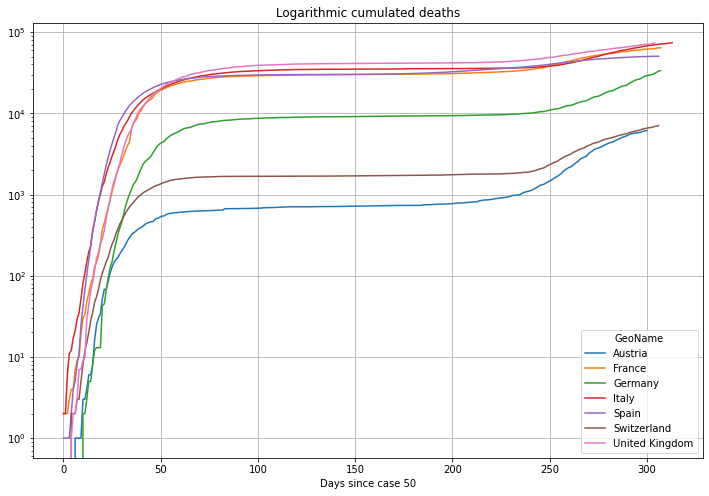

In [11]:

# the data starting at the first day after the cumalative cases have exceed 100 cases
numCasesStart = 50
# differntiate between a normal run and a github actions injected run path
df = covidCases.get_data_by_geoid_string_list(countryList, sinceNcases=numCasesStart)
  
# plot cumulated cases
(PlotterBuilder('Cases')
     .set_title('Cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('Cases')
     .set_title('Logarithmic cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# filter the data of the number of daily cases
df = covidCases.add_lowpass_filter_for_attribute(df, 'DailyCases', 7)

# plot the filtered daily cases
(PlotterBuilder('DailyCases7')
     .set_figsize((30, 12))
     .set_title('Daily cases 7 day average')
     .set_xaxis_index()
     .plot_dataFrame(df, ylim_min=0))

# plot cumulated cases
(PlotterBuilder('Deaths')
     .set_title('Cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('Deaths')
     .set_title('Logarithmic cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))



### The last N days

Lets take a closer look to the last 60 days. This time we will also look at the accumulated 7-day incidence. This is the sum of daily cases of the last 7 days divided by the population given in 100000 citizens. It basically tells you how many of 100000 people are infected in a country.

/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: invalid value encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])
/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: divide by zero encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])


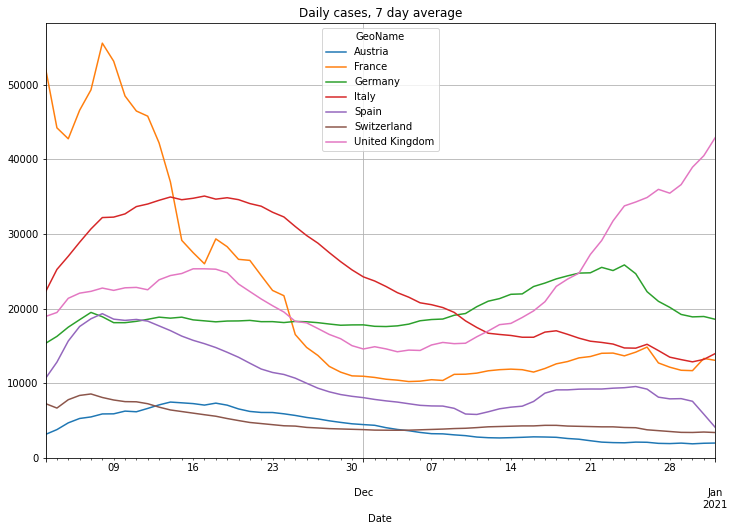

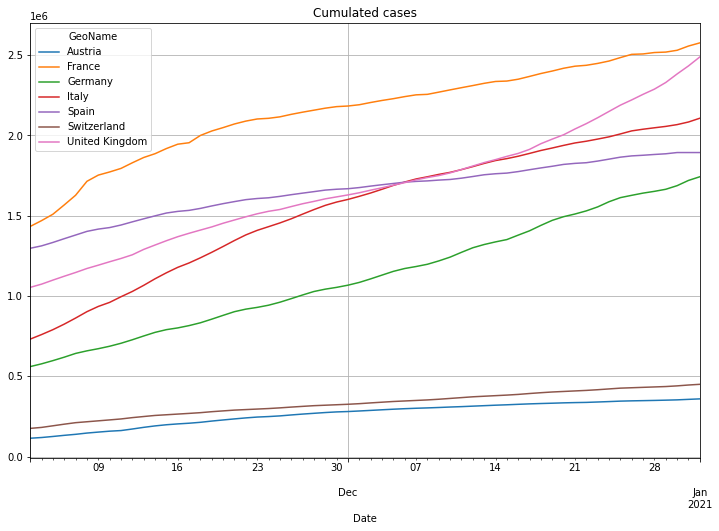

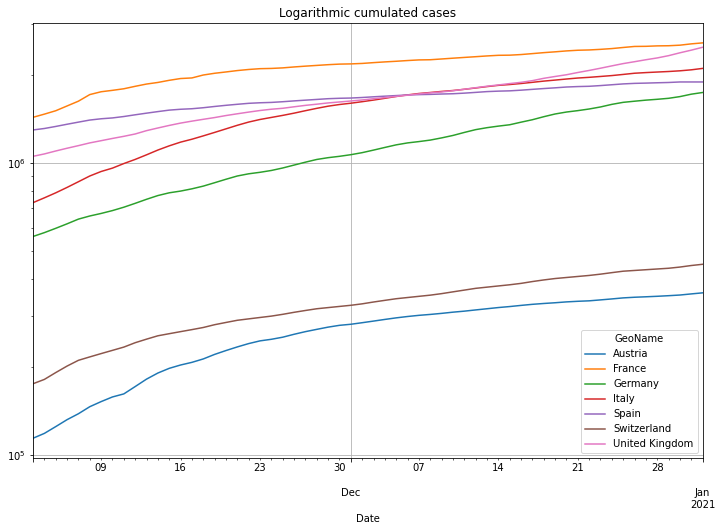

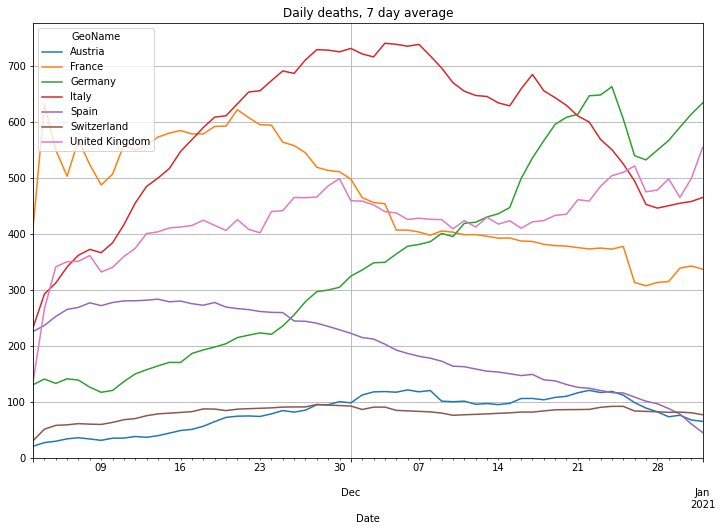

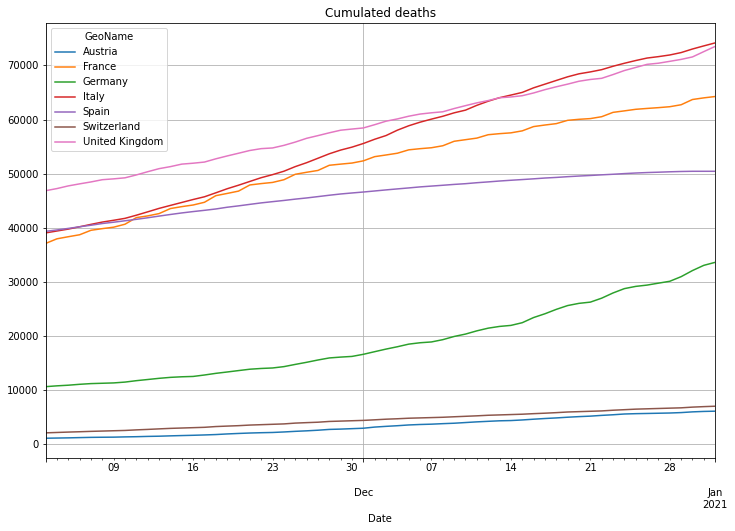

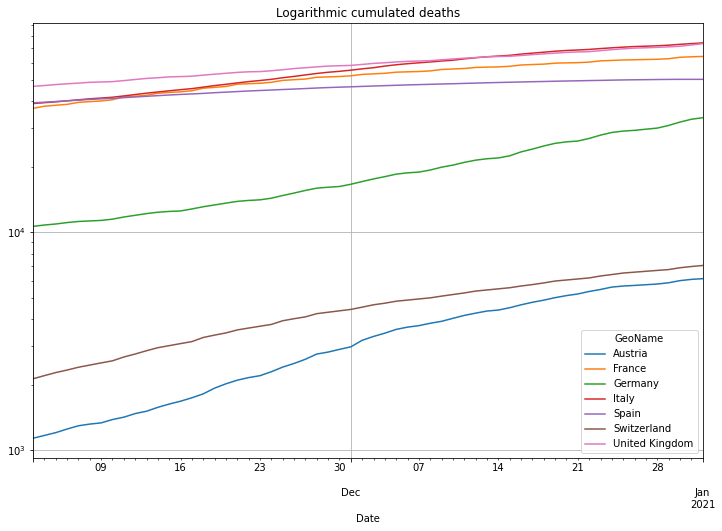

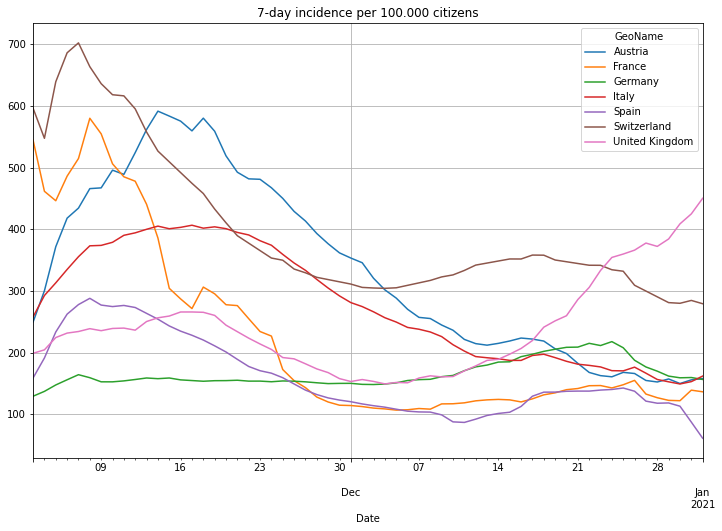

In [12]:

# the number of last days tolook at
numLastDays = 60

# get the data
df = covidCases.get_data_by_geoid_string_list(countryList, lastNdays=numLastDays)
    
# filter the data of the number of daily cases
df = covidCases.add_lowpass_filter_for_attribute(df, 'DailyCases', 7)

# plot daily cases
(PlotterBuilder('DailyCases7')
     .set_title('Daily cases, 7 day average')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df, ylim_min=0))

# plot cumulated cases
(PlotterBuilder('Cases')
     .set_title('Cumulated cases')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('Cases')
     .set_title('Logarithmic cumulated cases')
     #.set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'DailyDeaths', 7)

# plot daily cases
(PlotterBuilder('DailyDeaths7')
     .set_title('Daily deaths, 7 day average')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df, ylim_min=0))

# plot cumulated deaths
(PlotterBuilder('Deaths')
     .set_title('Cumulated deaths')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('Deaths')
     .set_title('Logarithmic cumulated deaths')
     #.set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# add the 7-day incidence
df = covidCases.add_incidence_7day_per_100Kpopulation(df)

# plot it
(PlotterBuilder('Incidence7DayPer100Kpopulation')
     .set_title('7-day incidence per 100.000 citizens')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))



### Estimating the reproduction number 

An important but difficult to calculate number is the basic reproduction number R0. The number defines how many people will be infected by one individual that is already infected. A number of 1.0 means that one infected person will infect one other person. As the original person will recover (or die) after some time, the number of infected people is constant. A number <1.0 means that the overall number of infected people will shrink, while a number >1.0 means that the overall number of infected people is increasing. This of course helps to predict the number of cases over time.   
The diffculty in calculating R0 is related to the at least 3 stages of an infection. In a first stage people are **S**usceptible for an infection, during the second stage people are **I**nfected and in the last stage they are **R**ecovered. The three characters S-I-R are giving the name for this model. The transition from stage to stage over time is what makes it diffcult to calculate the reproduction number R0. Refer to the SIR model and a online calculator:  
[https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)  
[http://covidsim.eu](http://covidsim.eu)  
  
The RKI published a method to calculate R0 here (German language):  
[https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile).    
  
The method is based on a so called *NowCasting*. Information about this can be found (German language) here:  
[https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y](https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y). 
  
Unfortunately the data provided by the WHO is not enough and we haven't implemented nowcasting so that we use a different method here. This method produces slightly different values but it produces the similar trend information. Compared to the data of the RKI this calculation shows an average difference to the RKI values of 6% with a maximum difference of 13% for the data in May.  
**Be aware!** The doubling number produces a good estimation during the exponential phase of a pandemic, while R0 can be used as an indicator of the progress of a pandemic during a more or less linear growth rate. So only look to R0 values between 0.0 and 2.5, maybe even 1.0 to 3.0. (**Notice**: UK did something very strange: early July they reported -30000 new cases. The fact that a country corrects previous numbers is somehow normal. But correcting 30000 cases at one day makes it very difficult to analyse the data. Because of that the UK numbers for R0 around the beginning of July are incorrect. 
  

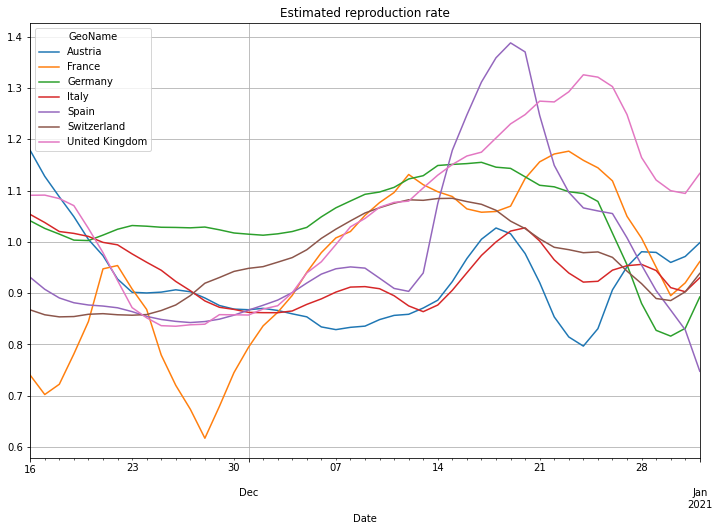

In [13]:

# get the unfiltered R number
df = covidCases.add_r0(df)
# apply a 7 day average
df = covidCases.add_lowpass_filter_for_attribute(df, 'R', 7)
# plot it
(PlotterBuilder('R7')
     .set_title('Estimated reproduction rate')
     #.set_xaxis_index()
     #.set_log()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))



### Generating heatmaps

To get a quick overview of the situation we generate heatmaps for different parameters and show them in a world map. A heatmap transforms a data value into a colour. The range of the value is between a given minimum and a given maximum which translates into a colour between blue and red. A blueish colour stands for a value close to the minimum while a redish colour stands for a value close to the maximum. The values in between range from turquoise over green and yellow to an orange and finally to a red like shown in the picture below:  

<img src="./jupyterData/heatMapBar.png">  

To render a map we use PyGal. The different naming conventions for GeoID's between PyGal and the WHO data adds a little hurdle. Refer to the source code of the heatmap class for more information.  
To generate the map we first need to get the GeoID's for all countries of the five continents and then get the data for all of these countries. That might take some time but finally the maps are giving a good overview to your own and the surrounding countries: 


/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: invalid value encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])
/Users/cmbt/Documents/GitHub/Covid-19-analysis/src/CovidCases.py:119: RuntimeWarning: divide by zero encountered in long_scalars
  quotient.append(value / dfSingleCountry['Cases'][index - 1])


Cases: 2021-01-01
Minimum: 27.0 Maximum: 19346790


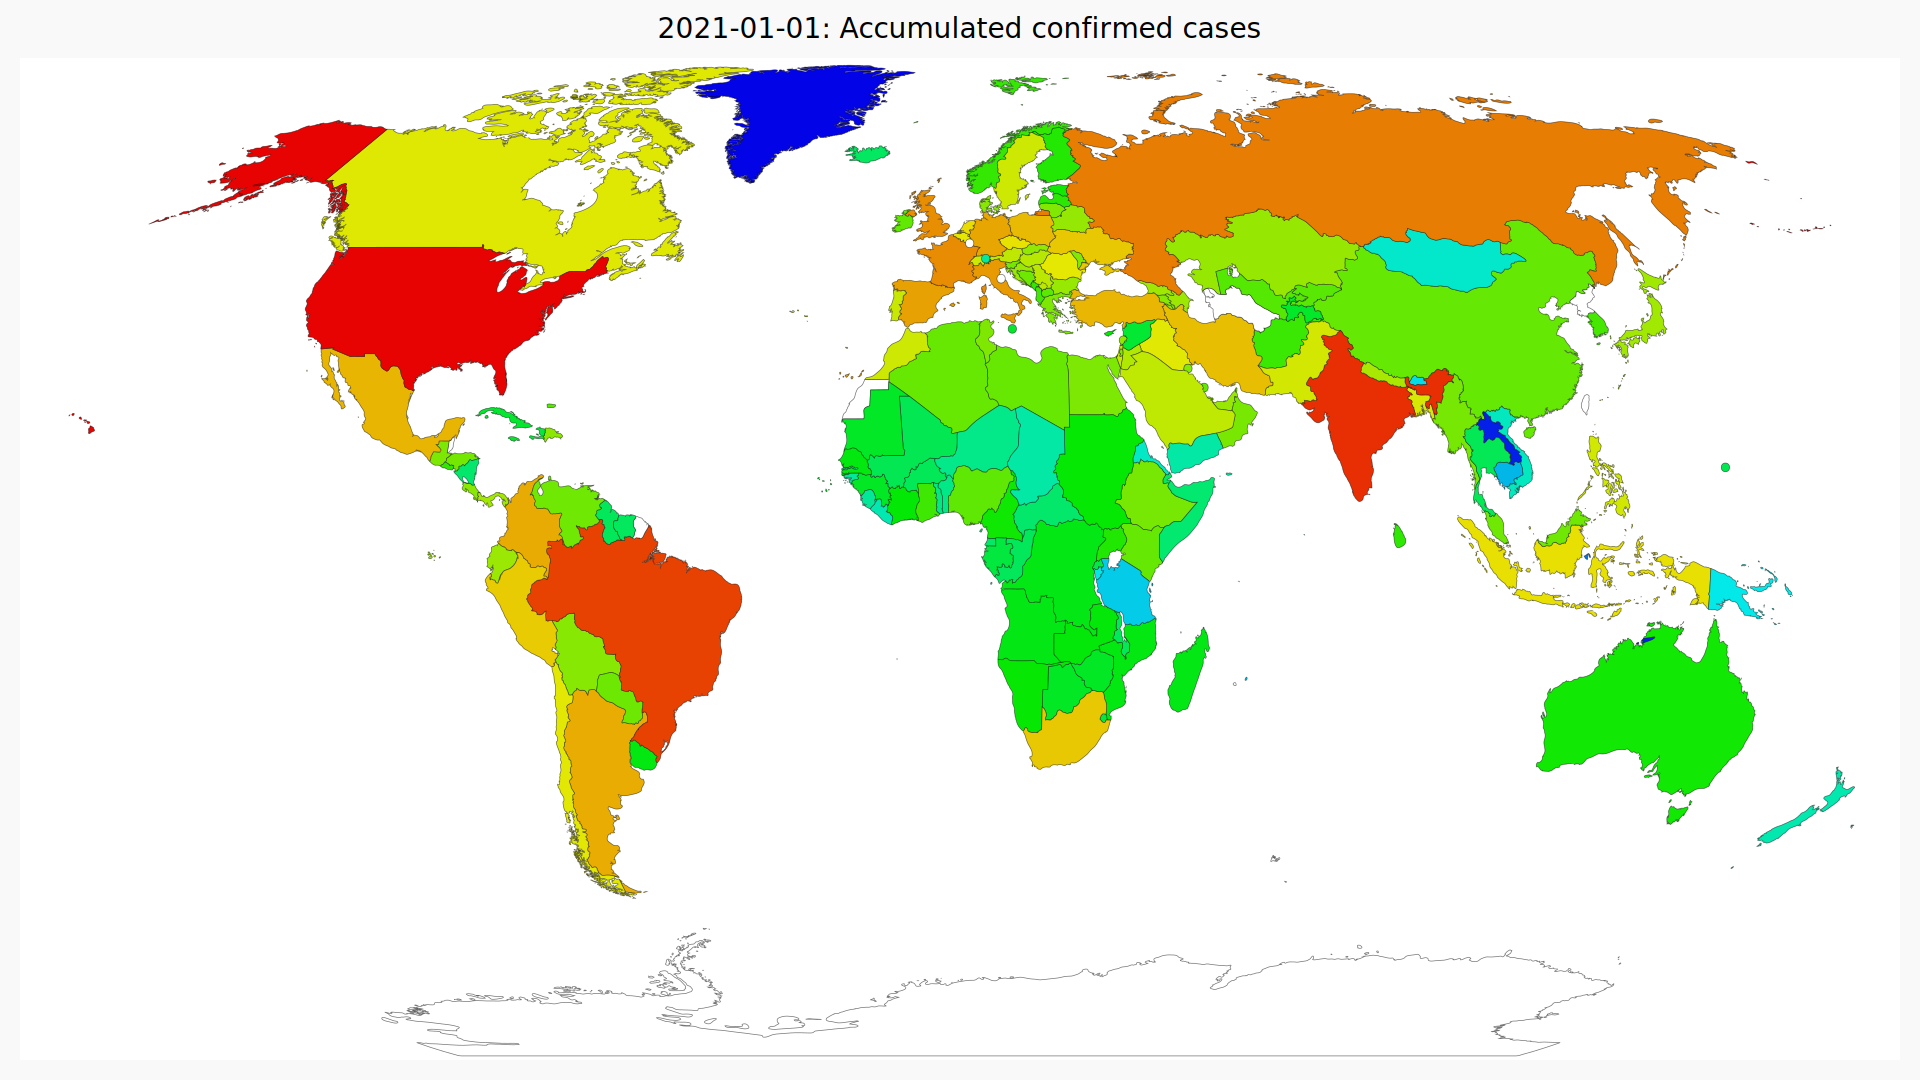

CasesPerMillionPopulation: 2021-01-01
Minimum: 5.718704459585218 Maximum: 77519.11820014079


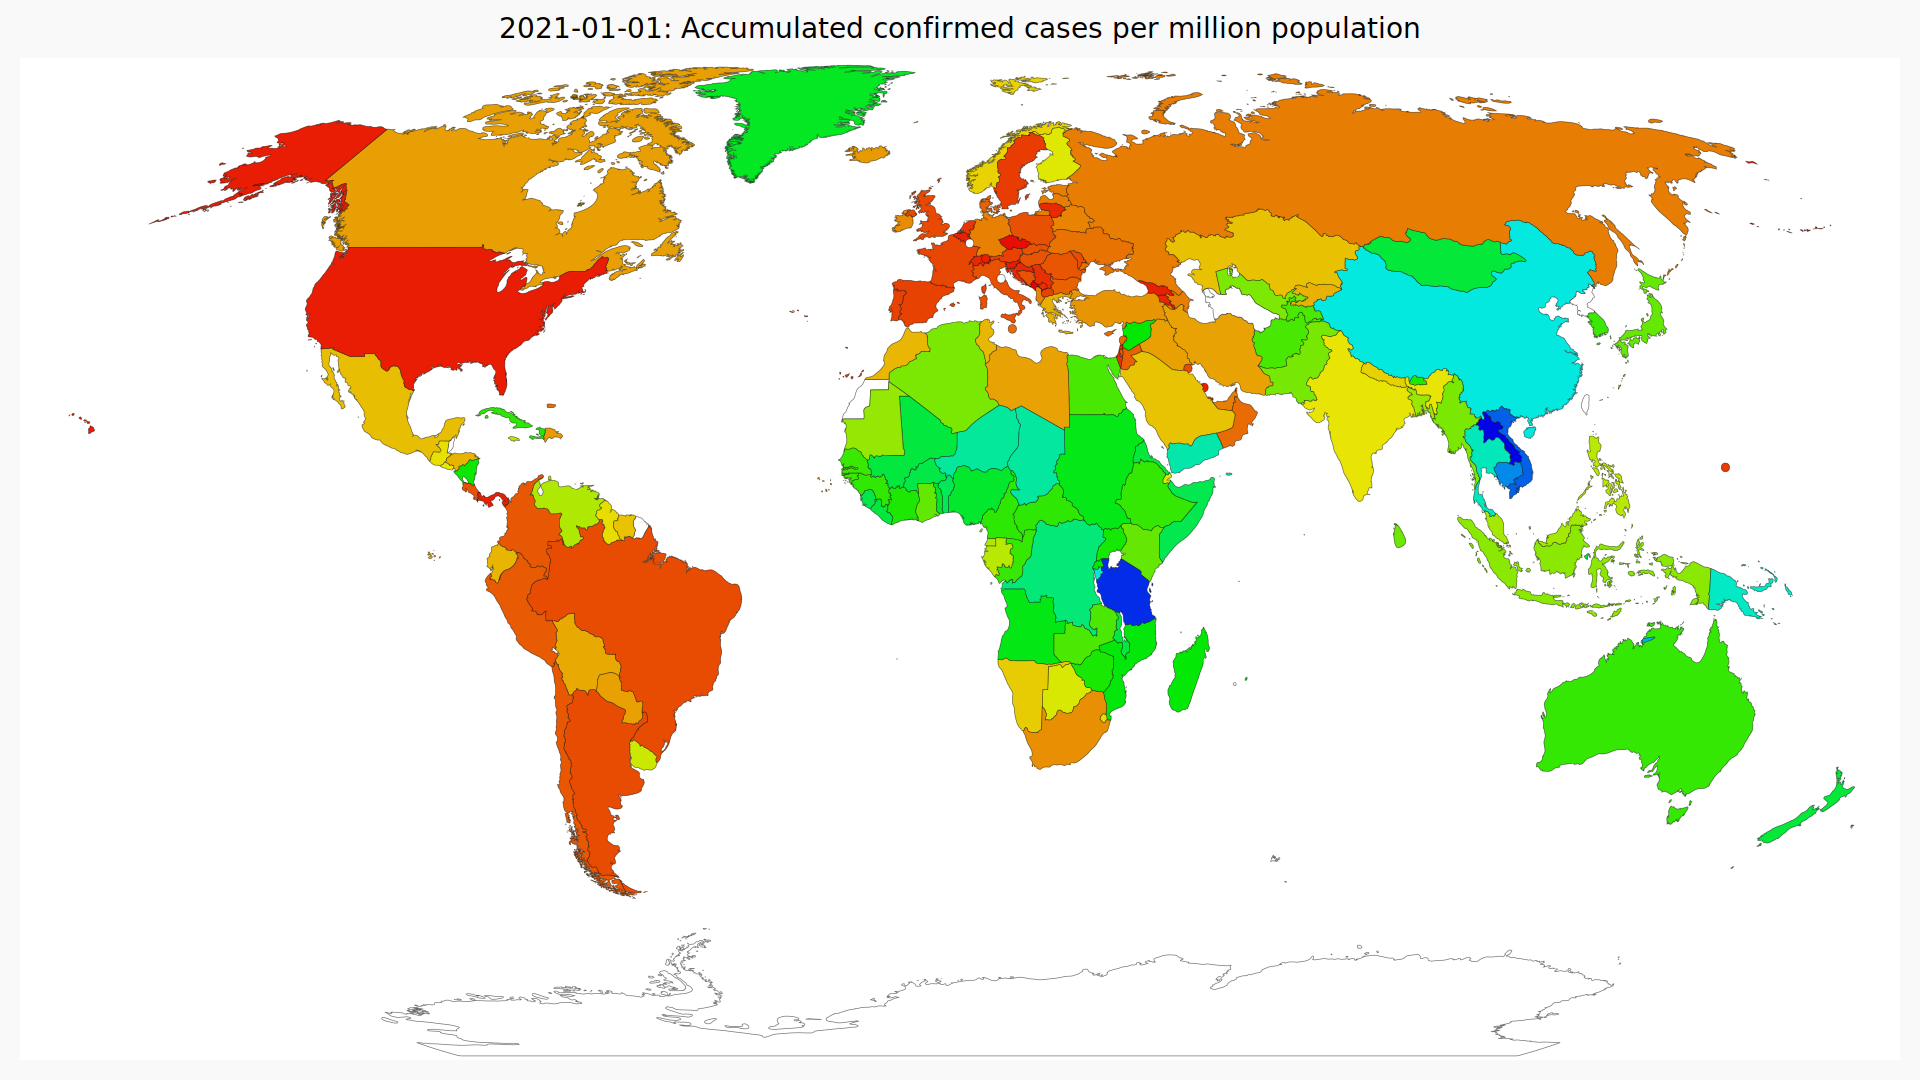

DeathsPerMillionPopulation: 2021-01-01
Minimum: 0.0 Maximum: 1704.6805125110436


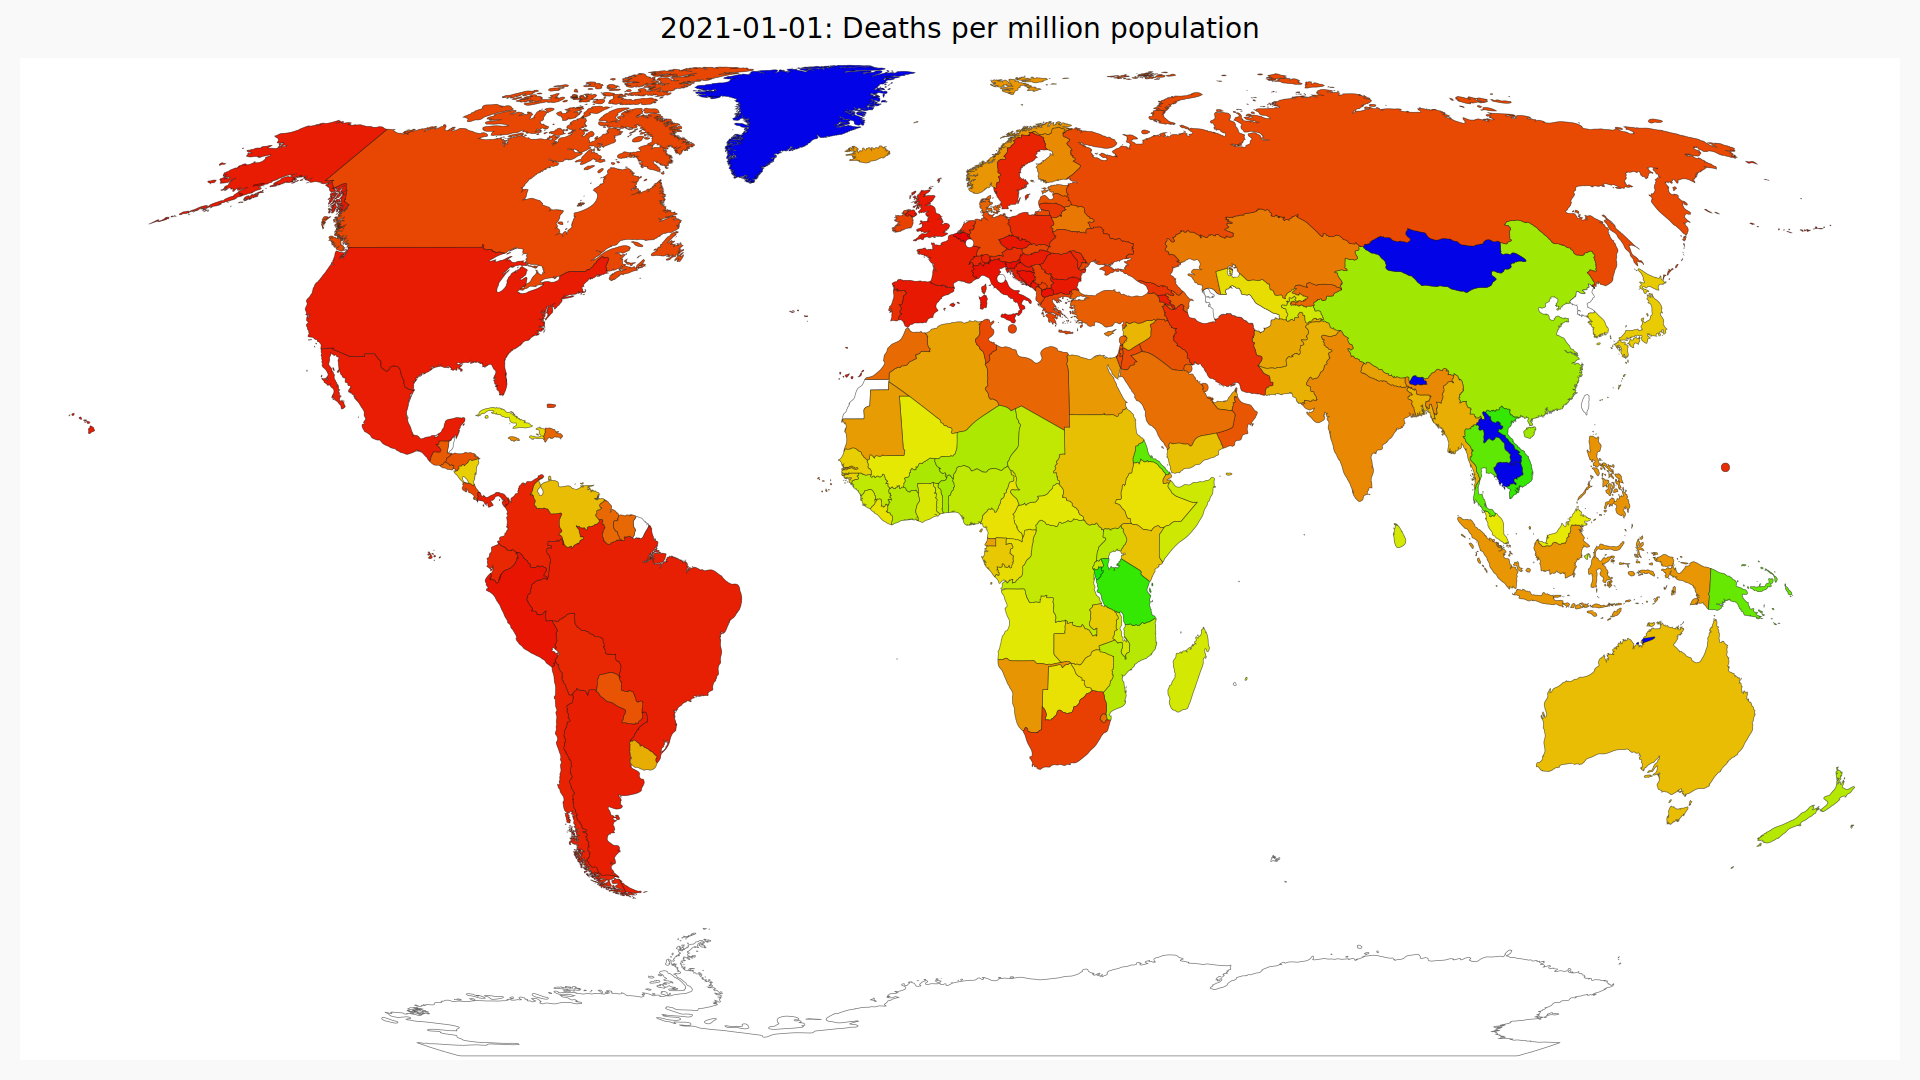

PercentDeaths: 2021-01-01
Minimum: 0.0 Maximum: 29.053732762719925


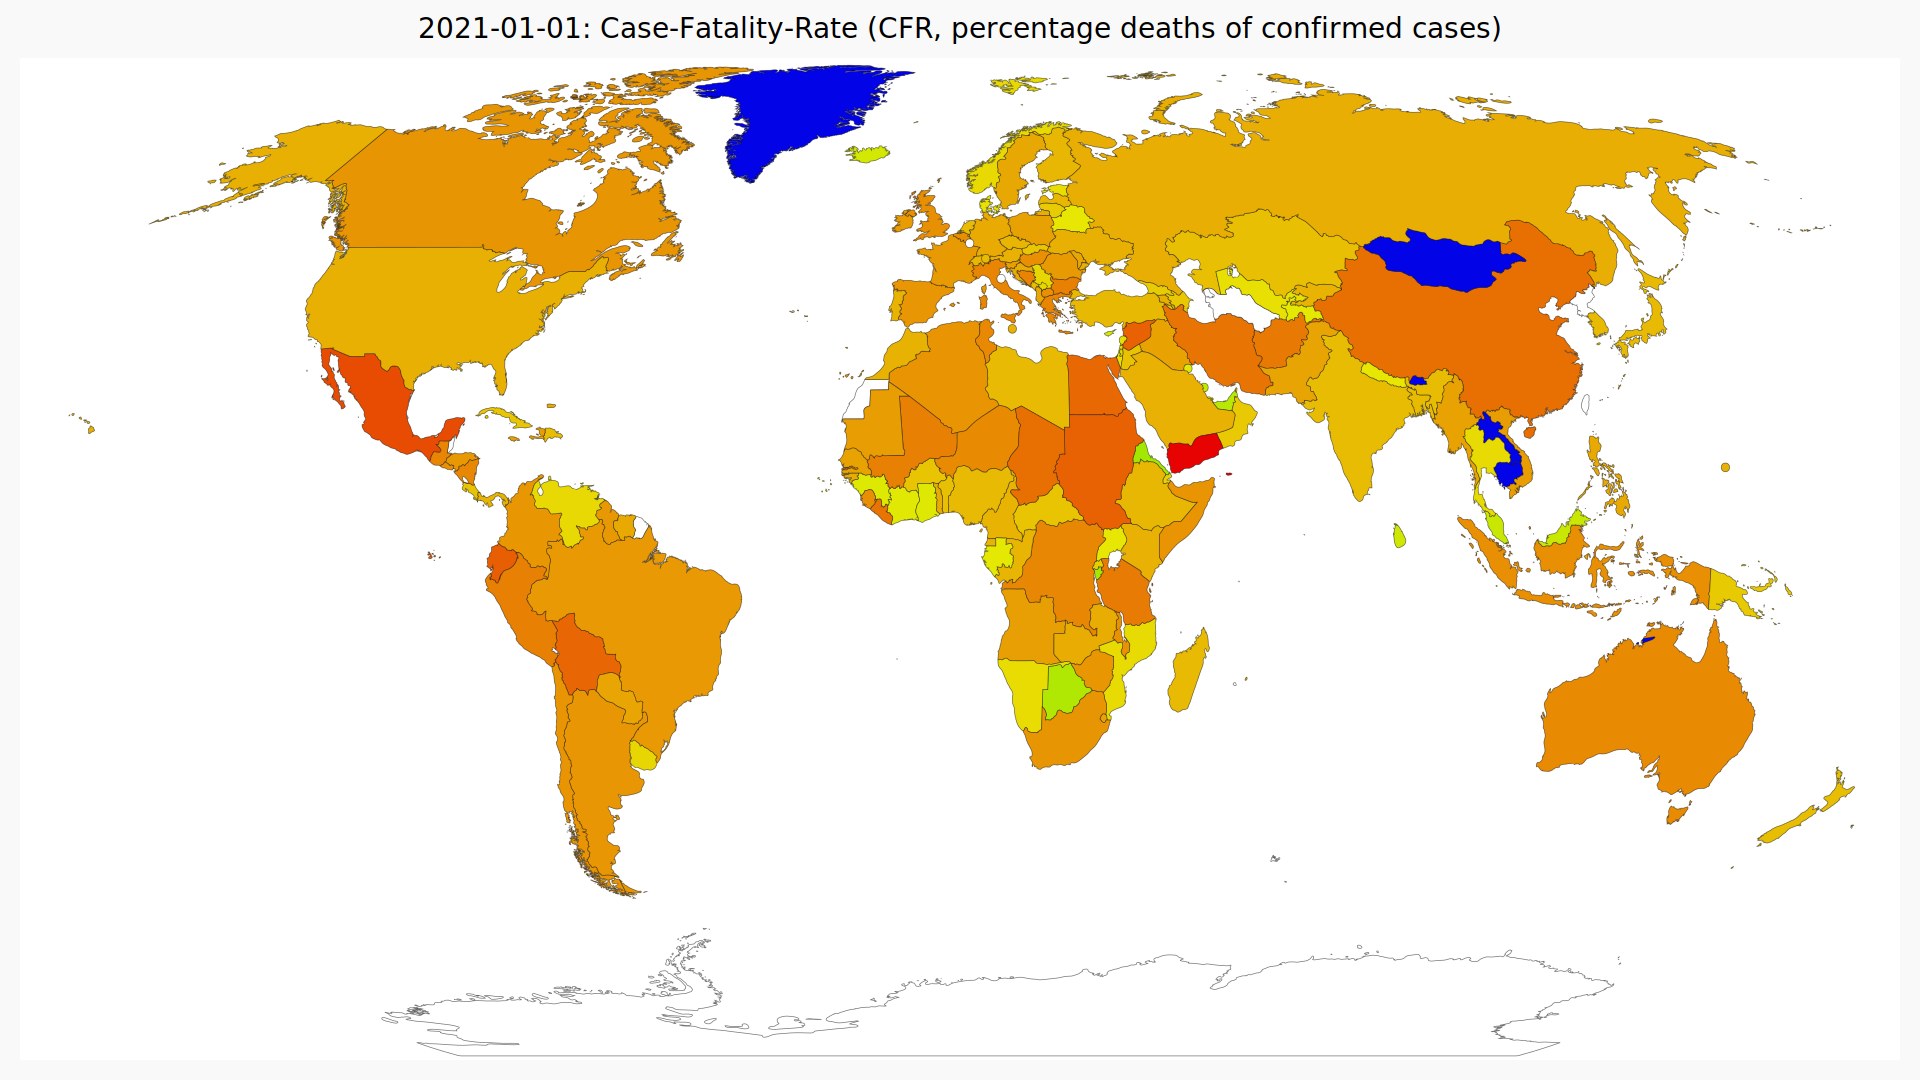

Incidence7DayPer100Kpopulation: 2021-01-01
Minimum: 0.0 Maximum: 630.6127814606847


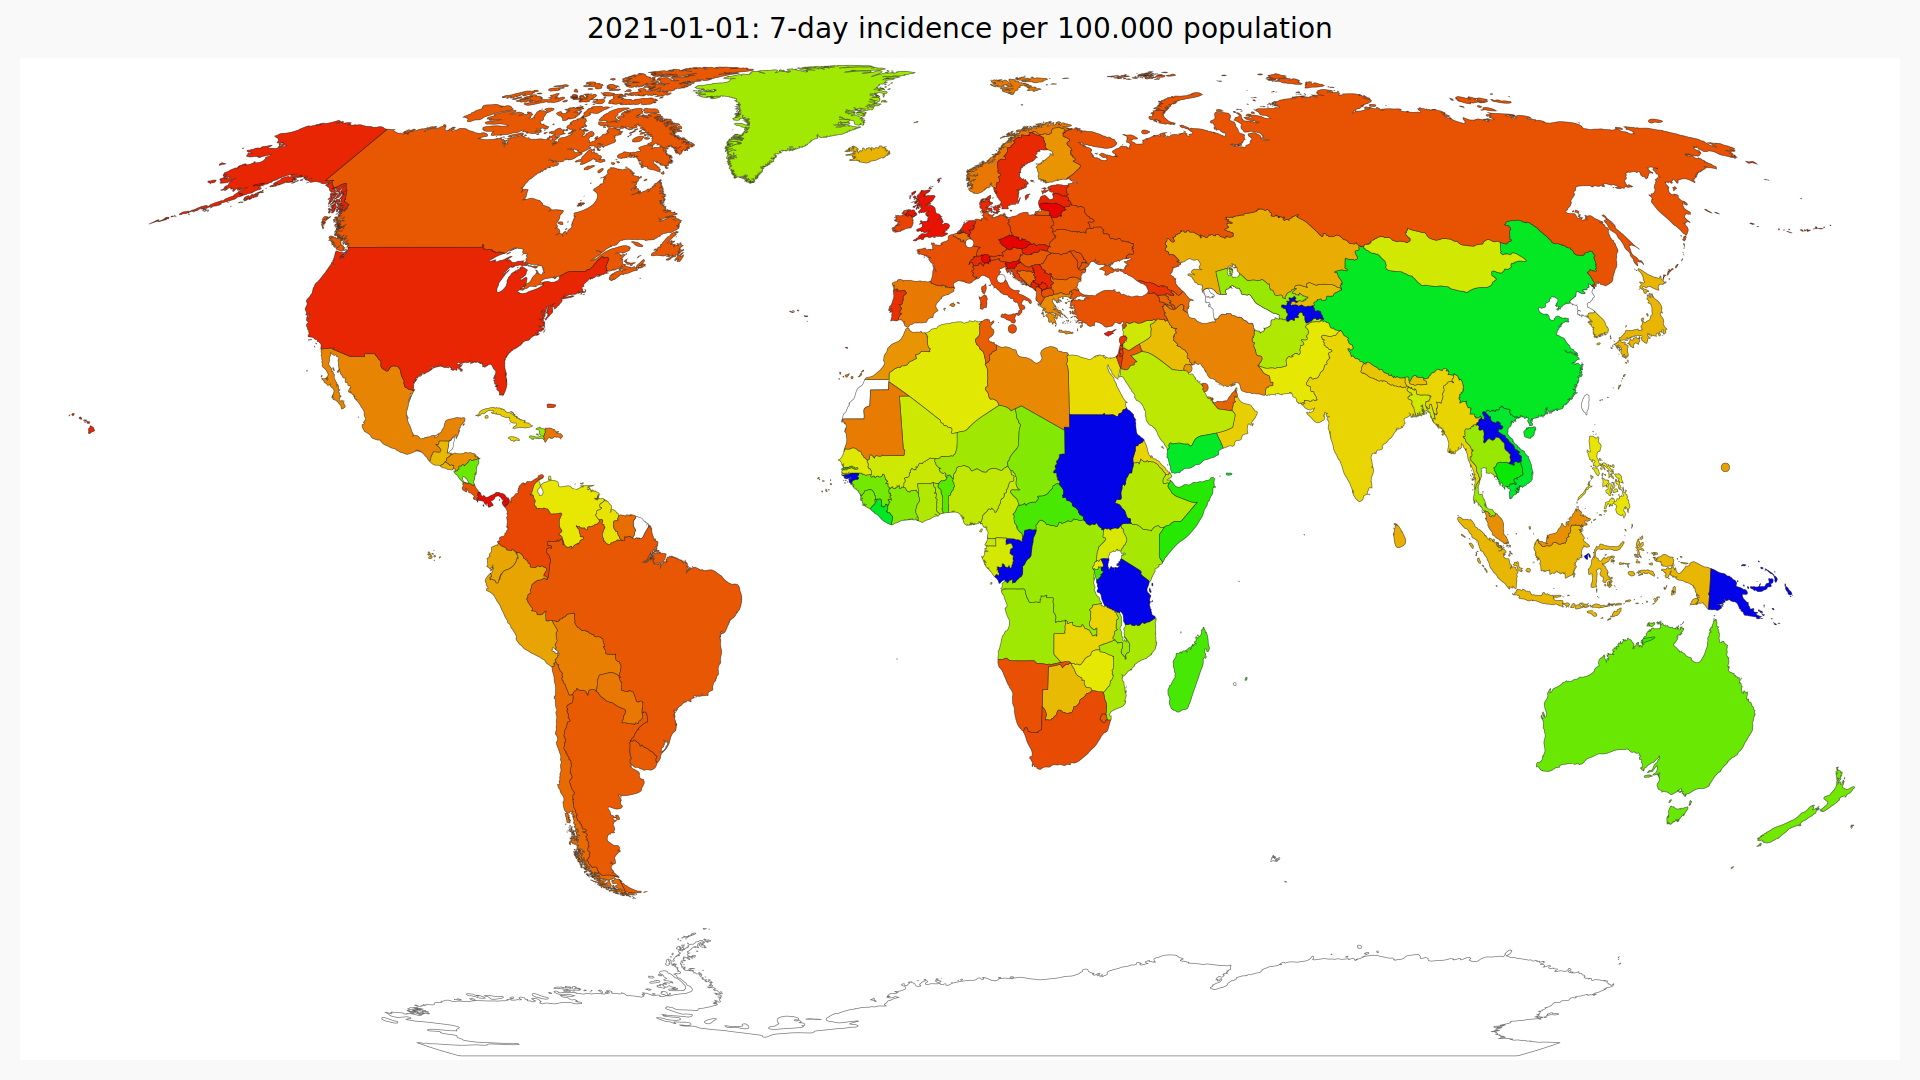

In [14]:
# the list of comma separated geoIDs for the major European countries
countryList = covidCases.get_pygal_american_geoid_string_list() + ',' + \
              covidCases.get_pygal_european_geoid_string_list() + ',' + \
              covidCases.get_pygal_african_geoid_string_list() + ',' + \
              covidCases.get_pygal_oceania_geoid_string_list() + ',' + \
              covidCases.get_pygal_asian_geoid_string_list()  

# get the dataframe for these countries
dfAll = covidCases.get_data_by_geoid_string_list(countryList)
# add the 7-day incidence
dfAll = covidCases.add_incidence_7day_per_100Kpopulation(dfAll)
# add the 7-day average of daily cases
dfAll = covidCases.add_lowpass_filter_for_attribute(dfAll, 'DailyCases', 7)

# create a map for the dataframe
map = dfm.CovidMap(dfAll)
# the root of the output directory
outputDirectory = '/Users/cmbt' + '/Desktop/tmp/Covid-animations/'

gis = []
# a list of requested maps
#gis.append(dfm.mapInfo("DailyCases7", '7-day average of daily confirmed cases', outputDirectory))
gis.append(dfm.mapInfo("Cases", 'Accumulated confirmed cases', outputDirectory))
gis.append(dfm.mapInfo("CasesPerMillionPopulation", 'Accumulated confirmed cases per million population', outputDirectory))
gis.append(dfm.mapInfo("DeathsPerMillionPopulation", 'Deaths per million population', outputDirectory))
gis.append(dfm.mapInfo("PercentDeaths", 'Case-Fatality-Rate (CFR, percentage deaths of confirmed cases)', outputDirectory))
gis.append(dfm.mapInfo("Incidence7DayPer100Kpopulation", '7-day incidence per 100.000 population', outputDirectory))

# get the maps
for gi in gis:
    # some countries (especially Spain) report the data pretty late in the evening of the currentday. You may want to see the previous day
    theDay = date.today() - timedelta(days=1)
    # generate the map
    result = map.create_map_for_date(gi, theDay)
    # display min/max
    print('Minimum: ' + str(result.minimum) + ' Maximum: ' + str(result.maximum))
    # display the map
    display(SVG(result.svg))
